# Unbounded Frank Wolfe algorithm

Implementation of the unbounded Frank Wolfe and unbounded step Away Frank Wolfe algorithms applied to a Lasso l1 trend filtering problem.

This code is based on Wang, H., Lu, H., & Mazumder, R. (2022). Frank--Wolfe Methods with an Unbounded Feasible Region and Applications to Structured Learning. SIAM Journal on Optimization, 32(4), 2938-2968.
https://arxiv.org/abs/2012.15361

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time
import cvxpy as cp
import mosek
# we use sparse in Mosek
import scipy.sparse as sparse 

## Data generation

In [14]:
def generate_data(N, n, r, num_segments, myseed, const1=1, const2=0.1):
    np.random.seed(myseed)
    # Generate A matrix
    A = np.random.randn(N, n)
    m = num_segments
    x = np.zeros(n)
    vals =  (2 * np.random.rand(m) - 1) # Generate m random values between -1 and 1 from N distribution
    
    for i in range(m):
        start_idx = int(i * n / m)
        end_idx = int((i + 1) * n / m)
        if r == 1:
            x[start_idx:end_idx] = vals[i]
            
        elif r == 2:
            segment_size = end_idx - start_idx
            incline = (vals[i] - vals[i-1]) / segment_size
            x[start_idx:end_idx] = vals[i-1] + incline * np.arange(segment_size)
            
            # Constraint
            tmp = np.arange(n) - np.mean(np.arange(n))
            B = np.column_stack((np.ones(n), tmp))
            Q = np.linalg.qr(B)[0]
            x = x - Q @ (Q.T @ x) + const1 + const2 * tmp
    
    # constraints
    if r == 1:
        Q = np.full((n, 1), 1 / np.sqrt(n))
        x = x - Q @ (Q.T @ x) + const1
    

    b0 = A @ x
    # Generate some random noise
    sigma_squared = N / (np.linalg.norm(A*x))**2 # since SNR=1 as defined end of the page 2958 we can define sigma_squared as
    #n / ||Ax*||^2 = sigma^2
    epsilon = np.random.normal(loc=0, scale=np.sqrt(sigma_squared), size=N) #create noise with iid N(0,sigma^2)
    # Introduce noise to the signal
    b = b0 + epsilon
    b = np.reshape(b, (N, 1))
    b0 = np.reshape(b0, (N, 1))

    return A, b, x

In [15]:
N=1000 # number of samples
n=500 # dimension of x
num_segments = 5 # number of pieces, think of it as the number of segments
myseed = 1

def data_plotting(N, n, r, num_segments, myseed):
    print('N = ', N, 'n = ', n, 'r = ', r, 'num_segments = ', num_segments, 'myseed = ', myseed)
    A, b, x = generate_data(N, n, r, num_segments, myseed)
    
    fig1 = plt.figure()
    plt.plot(b, label= 'b with noise: trend', color='darkorange')
    plt.legend()
    plt.show()
    
    fig2 = plt.figure()
    plt.plot(x, label= 'x: underlying picewise function')
    plt.legend()
    plt.show()

N =  1000 n =  500 r =  1 num_segments =  5 myseed =  1


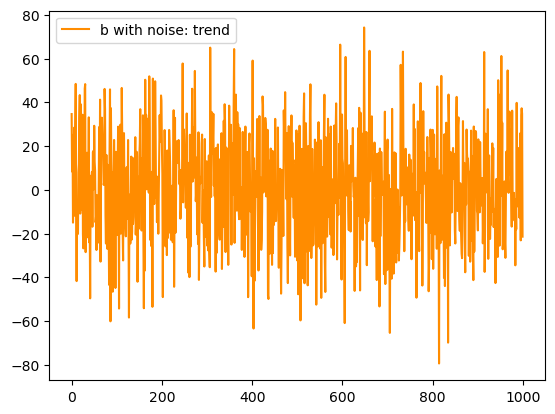

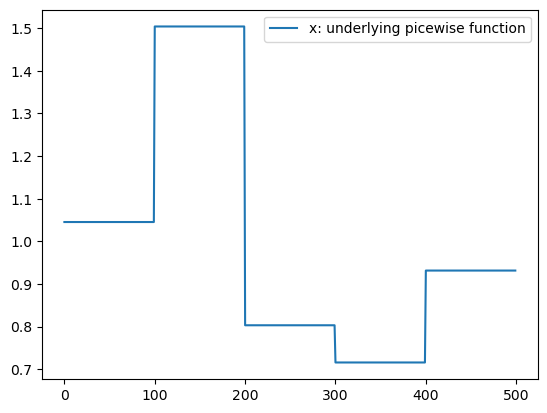

In [16]:
r = 1
data_plotting(N, n, r, num_segments, myseed)

N =  1000 n =  500 r =  2 num_segments =  5 myseed =  1


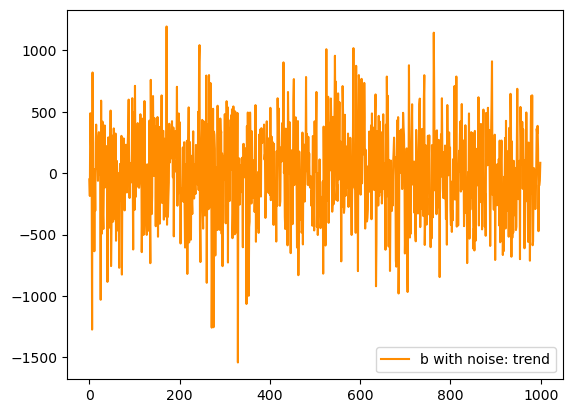

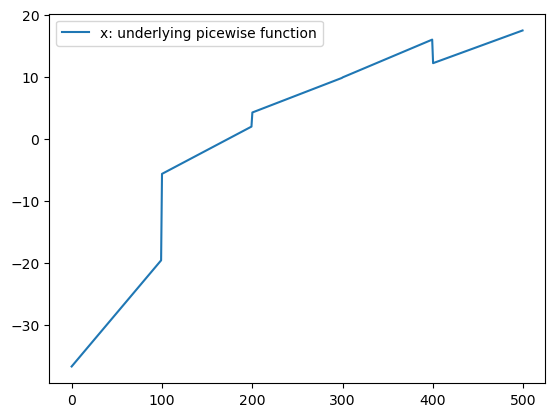

In [17]:
r = 2
data_plotting(N, n, r, num_segments, myseed)

## unbounded Frank Wolfe

Some auxiliary functions:

In [18]:
# Create the first order difference matrix for the T and S subspaces as well as 
# the constraint
def create_difference_matrix(n, r, k):
    """k = r, k is for iteration purposes"""
    if k == 1:
        D = np.zeros((n, n))
        np.fill_diagonal(D, 1)
        np.fill_diagonal(D[:, 1:], -1)
        return D
    else:
        D_prev = create_difference_matrix(n, r, k-1)
        D = np.dot(create_difference_matrix(n, r, 1), D_prev)
        return D
    
def difference_matrix(n, r, k):
    """returns the k th order difference matrix of size n - r x n"""
    assert k == r, 'k must be equal to r'
    return create_difference_matrix(n, r, k)[:n-r, :]

# This is the matrix that is created according to 4.1.2
def matrix_ID(matrix, n, r, D):
    for i in range(r):
        matrix = np.cumsum(matrix, axis=1)
    return matrix[:, 0:n - r] - np.dot(matrix[:, n -r : n], D)

Main uFW algo:

In [19]:
def uFW(A, b, r, delta, itermax = 2000, step_size = 'simple', gradient_ss='other'):
    
    assert gradient_ss in ['authors', 'operator_norm', 'other'], "gradient_ss must be 'authors', 'operator_norm', or 'other'"

    N, n = A.shape
        
    # Consider a constant gradient step size = 1/L
    L = 1
    

    timer = np.zeros(itermax)
    obj_val = np.zeros(itermax)
    G = np.zeros(itermax)
    H = np.zeros(itermax)

    
    ## 1. Intialization
    # 1.a Create our kth order difference matrix
    k_dif = r
    Dn = difference_matrix(n, r, k_dif)
    # 1.b Compute the null space of D
        # the null space or kernel is the set of all vectors that map to the zero vector
    T = scipy.linalg.null_space(Dn, rcond=None) # return the orthonormal basis for the null space of Dn
    # 1.c Compute the orthogonal complement of the null space of D
    # since T is an orthonormal basis for the null space of D, we can use the QR decomposition to find the orthogonal complement of the null space of D
    S, R = np.linalg.qr(T) # S is our orthogonal complement of the null space of D
    # 1.d Now we compute the direct sum of the subspaces
        # Given two subspaces A and B, their direct sum is denoted as A ⊕ B.
        # Geometrically, the direct sum represents all possible combinations of vectors 
        # that can be formed by taking one vector from subspace A and another vector
        # from subspace B. The resulting subspace will contain all vectors that can 
        # be expressed as the sum of a vector from A and a vector from B, without any 
        # overlap.
            # x0 being a member of the direct sum of the T and S subspaces is the 
            # feasible region (constraint)
    T_S = np.concatenate((T, S), axis=1)
    # x0 is a member of T_S
    x00 = T_S.T[0].reshape(-1, 1) # transpose T_S to get a column vector
    x = x00
    Q = T
    Q_copy = Q
    
    
    # For solving the linear optimization subproblem   
    for i in range(r):
        Q_copy = np.cumsum(Q_copy, axis=0)
    BT = Q_copy # gives cumulative sums up to sqrt(n) with equal intervals
    QTUR = BT.T
    # see 4.1.2
    B1 = QTUR[:, : n - r]
    B2 = QTUR[:, n - r:n]
    D = np.dot(np.linalg.inv(B2), B1) # this is w in 4.1.2
    # inverse of B2 matrix multiplicate by B1 is equal to D, represents the transformation matrix 
    # that relates the coordinates in the subspace ker(D^(r)) (spanned by the orthogonal basis F) to the coordinates 
    # in the original space. It captures the linear relationship between the subspace and the original space, allowing for
    # the projection of vectors onto the subspace or other computations involving the subspace. 
       

# After finding our starting point x_init, now we need to take the gradient step in the unbounded direction 
# by projecting the vectors onto the linear space via orthogonal basis, in this way the computational expense will be cheaper.
# First we calculated the required matrixes to project onto T
    AID = matrix_ID(A, n, r, D)

    Diag_1 = np.eye(n) #Return a 2-D array with ones on the diagonal and zeros elsewhere.
    DID = matrix_ID(Diag_1, n, r, D)

    ATA = np.dot(A.T,  A) # A transpose dot A
    ATAID = matrix_ID(ATA, n, r, D)
    
    Ax = np.dot(A, x)
    ATAQ = np.dot(ATA, Q)
    ATAx = np.dot(ATA, x)
    ATb = np.dot(A.T, b)
    
# It is time to start our timer since we are starting the algorithm 
    time_0 = time.time()
    
    for k in range(itermax): # we need to compute the largest singular value/ vector pair at every iteration
        Ax_b = Ax - b
        obj_val[k] = 0.5*np.linalg.norm(Ax_b)**2
        
        ## take gradient step in the unbounded direction
        grad = ATAx - ATb 
        Qt_grad = np.dot(Q.T, grad)
        Pt_grad = np.dot(Q, Qt_grad)
        APt_grad = np.dot(np.dot(A, Q), Qt_grad)
        ATAPt_grad = np.dot(ATAQ, Qt_grad)
        
        # Gradient descent step size selection
        if gradient_ss == 'authors':
            while True:
                y = x - (1/L)*Pt_grad
                Ay = Ax - (1/L)*APt_grad
                ATAy = ATAx - (1/L)*ATAPt_grad
                Ay_b = Ay - b
                if ((1-1e-10)*0.5*np.linalg.norm(Ay_b)**2 <= 0.5*np.linalg.norm(Ax_b)**2 
                    + Ax_b.T@(Ay-Ax) + (L/2)*np.linalg.norm(y-x00)**2):
                    break
                if k % 100== 0:
                    print('k=', k)
                    print('grad max=', abs(grad).max())
                    print('L= ', L)
                L = L*2
        elif gradient_ss == 'operator_norm':
            L = np.linalg.norm(A, ord=2)
            if k % 100== 0:
                print('k=', k)
                print('grad max=', abs(grad).max())
                print('L= ', L)
            y = x - (1 / L) * Pt_grad  
            Ay = Ax - (1 / L) * APt_grad
            ATAy = ATAx - (1 / L) * ATAPt_grad
            Ay_b = Ay - b
        else: # add the other step size we want to use
            L = np.absolute(grad).max()
            if k % 100== 0:
                print('k=', k)
                print('grad max=', abs(grad).max())
                print('L= ', L)
            y = x - (1 / L) * Pt_grad  
            Ay = Ax - (1 / L) * APt_grad
            ATAy = ATAx - (1 / L) * ATAPt_grad
            Ay_b = Ay - b
            



        grad = ATAy - ATb
        Pt_grad = np.dot(Q , np.dot(Q.T, grad)) #projection onto space T which will be used in the comparison metric H

        AQ = np.dot(A, Q)
        Qt_y = np.dot(Q.T, y)
        Pt_y = np.dot(Q, Qt_y)
        APt_y = np.dot(AQ, Qt_y)
        ATAPt_y = np.dot(ATAQ, Qt_y)

        ## Compute the FW step
        
        # to compute the Fw step first we need to find which column to perform scaling
        tilde_c = grad #gradient of the objective function in the current point
        for i in range(r):
            tilde_c = np.cumsum(tilde_c, axis=0)
        cc = tilde_c[0:n - r] - np.dot(D.T, tilde_c[n - r:n]) #This operation removes the contribution of the last r elements of tilde_c based on the matrix D.
        cc = np.reshape(cc, (n - r,))

        FW_index = np.argmax(np.abs(cc)) #finding the largest value/vector
        s_dir = -np.sign(cc[FW_index]) # we are determining the direction of the step here
        x_FW = DID[:, FW_index] * s_dir * delta #pick the column that includes largest value and scale it by the step direction
        x_FW = np.reshape(x_FW, (n, 1))
        Ax_FW = AID[:, FW_index] * s_dir * delta #doing the same but this time for the space given by A
        Ax_FW = np.reshape(Ax_FW, (N, 1))

        #After scaling the right columns we find the direction on both original space and A, algorithm moves towards the optimal solution while respecting the constraints defined by the feasible set
        #diff = x_FW - (y - Pt_y)
        diff = x_FW - (x - Q @ Q.T @ x)
        A_diff = Ax_FW - (Ay - APt_y)
        
        
        # FW step size
        if step_size == 'linesearch':
            t1 = -(Ay_b.T @ A_diff) 
            t2 = np.linalg.norm(A_diff) ** 2
            step = max(min(t1 / t2, 1), 0)
        else:
            step = 2 / (k + 2)

        # we find the current state of x after the step
        x = y + step * diff
        Ax = Ay + step * A_diff # and on the feasible set defined by constraints
        
        
        ATAx_FW = ATAID[:, FW_index] * s_dir * delta
        ATAx_FW = np.reshape(ATAx_FW, (n, 1)) #projection on the dual space
        ATAd = ATAx_FW - (ATAy - ATAPt_y) 
        ATAx = ATAy + step * ATAd #taking the step in dual as well
        
    # Here we record the comparison metrics before finishing the loop step
        H[k] = np.linalg.norm(Pt_grad)
        G[k] = -np.dot(grad.T,  diff)

        # Record the time
        timer[k] = time.time() - time_0
    
    x= np.reshape(x, (n,))
    
    return x, timer, obj_val, G, H

## unbounded step Away Frank Wolfe

uAFW after changes

In [20]:
def uAFW(r, A, b, delta, itermax = 2000, gradient_ss= 'other'):
    timer = np.zeros(itermax)
    obj_val = np.zeros((itermax, ))
    G = np.zeros((itermax, ))
    H = np.zeros((itermax, ))
    N, n = A.shape
    
    assert gradient_ss in ['authors', 'operator_norm', 'other'], "gradient_ss must be 'authors', 'operator_norm', or 'other'"

    # Set gradient descent step size = 1/L
    L = 1
    
    ## 1. Intialization
    # 1.a Create our kth order difference matrix
    k_dif = r
    Dn = difference_matrix(n, r, k_dif)
    # 1.b Compute the null space of D
            # the null space or kernel is the set of all vectors that map to the zero vector
    T = scipy.linalg.null_space(Dn, rcond=None) # return the orthonormal basis for the null space of Dn
    # 1.c Compute the orthogonal complement of the null space of D
    # since T is an orthonormal basis for the null space of D, we can use the QR decomposition to find the orthogonal complement of the null space of D
    S, R = np.linalg.qr(T) # S is our orthogonal complement of the null space of D
    # 1.d Now we compute the direct sum of the subspaces
        # Given two subspaces A and B, their direct sum is denoted as A ⊕ B.
        # Geometrically, the direct sum represents all possible combinations of vectors 
        # that can be formed by taking one vector from subspace A and another vector
        # from subspace B. The resulting subspace will contain all vectors that can 
        # be expressed as the sum of a vector from A and a vector from B, without any 
        # overlap.
            # x0 being a member of the direct sum of the T and S subspaces is the 
            # feasible region (constraint)
    T_S = np.concatenate((T, S), axis=1)
    # x0 is a member of T_S
    x00 = T_S.T[0].reshape(-1, 1) # transpose T_S to get a column vector
    x = x00
    F = T
    F_copy = F
    
    
    for i in range(r): 
        F_copy = np.cumsum(F_copy, axis=0)
    BT = F_copy # gives cumulative sums up to sqrt(n) with equal intervals
    B = BT.T
    B1 = B[:, 0:n - r]
    B2 = B[:, n - r:n]
    D = np.dot(np.linalg.inv(B2), B1) #inverse of B2 matrix multiplicate by B1 is equal to D
                    #, represents the transformation matrix that relates the coordinates in the subspace ker(D^(r)) 
                    #(spanned by the orthogonal basis F) to the coordinates in the original space. 
                    #It captures the linear relationship between the subspace and the original space
                    #, allowing for the projection of vectors onto the subspace or other computations involving the subspace.

    
# After finding our starting point x_init, now we need to take the gradient step in the unbounded direction 
# by projecting the vectors onto the linear space via orthogonal basis, in this way the computational expense will be cheaper.
# First we calculated the required matrixes to project onto T   
    #x = x_init
    Ax = np.dot(A, x)
    AF = np.dot(A, F)
    AUrID = matrix_ID(A, n, r, D)

    Diag_1 = np.eye(n) #Return a 2-D array with ones on the diagonal and zeros elsewhere.
    UrID = matrix_ID(Diag_1, n, r, D)

    ATA = np.dot(A.T,  A) # A transpose dot A
    ATb = np.dot(A.T, b)
    ATAUrID = matrix_ID(ATA, n, r, D)

    ATAF = np.dot(ATA, F)
    ATAx = np.dot(ATA, x)

# It is time to start our timer since we are starting the algorithm 
    time_0 = time.time()

    ver_set = np.zeros((2, n - r))
    al = np.zeros((2, n - r))
    ver_set[0, 0] = 1
    al[0, 0] = 1

    for k in range(itermax): # we need to compute the largest singular value/ vector pair at every iteration
        Ax_b = Ax - b
        obj_val[k] = 0.5*np.linalg.norm(Ax_b)**2

        ## take gradient step in the unbounded direction        
        grad = ATAx - ATb
        Ft_grad = np.dot(F.T, grad)
        Pt_grad = np.dot(F, Ft_grad)
        APt_grad = np.dot(AF, Ft_grad) 
        ATAPt_grad = np.dot(ATAF, Ft_grad)
        

        # Gradient descent step size selection
        if gradient_ss == 'authors':
            while True:
                y = x - (1/L)*Pt_grad
                Ay = Ax - (1/L)*APt_grad
                ATAy = ATAx - (1/L)*ATAPt_grad
                Ay_b = Ay - b
                if ((1-1e-10)*0.5*np.linalg.norm(Ay_b)**2 <= 0.5*np.linalg.norm(Ax_b)**2 
                    + Ax_b.T@(Ay-Ax) + (L/2)*np.linalg.norm(y-x00)**2):
                    break
                if k % 100== 0:
                    print('k=', k)
                    print('grad max=', abs(grad).max())
                    print('L= ', L)
                L = L*2
        elif gradient_ss == 'operator_norm':
            L = np.linalg.norm(A, ord=2)
            if k % 100== 0:
                print('k=', k)
                print('grad max=', abs(grad).max())
                print('L= ', L)
            y = x - (1 / L) * Pt_grad  
            Ay = Ax - (1 / L) * APt_grad
            ATAy = ATAx - (1 / L) * ATAPt_grad
            Ay_b = Ay - b
        else: # add the other step size we want to use
            # L is the inverse of BB method
            L = np.absolute(grad).max()
            if k % 100== 0:
                print('k=', k)
                print('grad max=', abs(grad).max())
                print('L= ', L)
            y = x - (1 / L) * Pt_grad  
            Ay = Ax - (1 / L) * APt_grad
            ATAy = ATAx - (1 / L) * ATAPt_grad
            Ay_b = Ay - b
            
        
        
        

        grad = ATAy - ATb
        Pt_grad = np.dot(F , np.dot(F.T, grad))
        H[k] = np.linalg.norm(Pt_grad)

        Ft_y = np.dot(F.T, y)
        Pt_y = np.dot(F, Ft_y)
        APt_y = np.dot(AF, Ft_y)
        ATAPt_y = np.dot(ATAF, Ft_y)

        ## Compute the FW step
        
        # to compute the Fw step first we need to find which column to perform scaling
        tilde_c = grad #gradient of the objective function in the current point
        for i in range(r):
            tilde_c = np.cumsum(tilde_c, axis=0)
        cc = tilde_c[0:n - r] - np.dot(D.T, tilde_c[n - r:n]) #This operation removes the contribution of the last r 
                                                              #elements of tilde_c based on the matrix D.
        cc = np.reshape(cc, (n - r,))

        ## away step
        cc_cc = np.zeros((2, n - r))
        cc_cc[0] = cc
        cc_cc[1] = -cc
        active_cc = ver_set * cc_cc
        flat_index = np.flatnonzero(active_cc)
        flat_ac_cc = active_cc.ravel()[flat_index] #finds the flat index of the non-zero elements in active_cc and stores them in flat_index
        pivot_iin = np.argmax(flat_ac_cc) #identifies the index of the maximum value in flat_ac_cc 
        flat_pivot_index = flat_index[pivot_iin]

        if flat_pivot_index > n - r - 1: #if flat_pivot_index is greater than n - r - 1, it means the pivot element is in the second row of active_cc 
            u_away_index = flat_pivot_index - (n - r) #calculates the index of the away direction in the vertex set
            #according to direction multiply with -delta or delta
            u_away_setindex = (1, u_away_index)
            x_away = UrID[:, u_away_index] * (-delta) 
            x_away = np.reshape(x_away, (n, 1))
            Ax_away = AUrID[:, u_away_index] * (-delta)
            Ax_away = np.reshape(Ax_away, (N, 1))
            ATAx_away = ATAUrID[:, u_away_index] * (-delta)
            ATAx_away = np.reshape(ATAx_away, (n, 1))
        else: #else, the pivot element is in the first row of active_cc
            u_away_index = flat_pivot_index
            u_away_setindex = (0, u_away_index)
            x_away = UrID[:, u_away_index] * (delta)
            x_away = np.reshape(x_away, (n, 1))
            Ax_away = AUrID[:, u_away_index] * (delta)
            Ax_away = np.reshape(Ax_away, (N, 1))
            ATAx_away = ATAUrID[:, u_away_index] * (delta)
            ATAx_away = np.reshape(ATAx_away, (n, 1))

        ## FW step
        u_FW = np.zeros((n - r, 1))
        u_FW_index = np.argmax(np.abs(cc))
        u_FW[u_FW_index] = -np.sign(cc[u_FW_index]) * delta

        sgn = -np.sign(cc[u_FW_index])
        x_FW = UrID[:, u_FW_index] * delta * sgn #pick the column that includes largest value and scale it by the step direction
        x_FW = np.reshape(x_FW, (n, 1))
        Ax_FW = AUrID[:, u_FW_index] * delta * sgn #doing the same but this time for the space given by A
        Ax_FW = np.reshape(Ax_FW, (N, 1))
        ATAx_FW = ATAUrID[:, u_FW_index] * delta * sgn #projection on the dual space
        ATAx_FW = np.reshape(ATAx_FW, (n, 1))

        ## take the step
        d_away = (x - F @ F.T @ x) - x_away
        d_FW = x_FW - (x - F @ F.T @ x)
        
        if np.dot(grad.T, d_FW) < np.dot(grad.T, d_away): #If this condition is satisfied, it means that the FW step should be taken
            flag = 1 #indicating that the FW step has been selected
            d = d_FW
            Ad = Ax_FW - (Ay - APt_y) #the linear approximation of the change in the objective function corresponding to the FW direction
            ATAd = ATAx_FW - (ATAy - ATAPt_y)
            step_max = 1 #If the FW step is taken, it sets the flag to 1 and assigns the step direction "d" and the corresponding A*d values "Ad" based on the FW direction. It also sets the maximum step size "step_max" to 1
            #indicating that the step can go up to the full FW direction.
        else: #away step
            flag = 0
            d = d_away
            Ad = (Ay - APt_y) - Ax_away
            ATAd = (ATAy - ATAPt_y) - ATAx_away
            alpha = al.ravel()[flat_pivot_index]
            if alpha < 1 - 1e-10: #the active vertex is not fully fixed and has a positive weight
                step_max = alpha / (1 - alpha)
            else:
                step_max = 1e10

        #After finding the direction we can calculate the step size on that direction which is defined in 2.1 in the article
        t1 = -np.dot(Ay_b.T, Ad)
        t2 = np.linalg.norm(Ad) ** 2
        step = max(min(t1 / t2, step_max), 0) # here the maximum step is 1 and the minimum step size is 0 which means no-move
        
        # we find the current current state of after the step
        x = y + step * d
        Ax = Ay + step * Ad # and on the feasible set defined by constraints
        ATAx = ATAy + step * ATAd #taking the step in dual as well

        # Here we record the comparison metrics before finishing the loop step
        G[k] = -np.dot(grad.T,  d)

        ### Update active vertex and weights
        if flag == 1:  #FW step is taken
            if step == 1: #the current iteration corresponds to a complete FW step
                ver_set = np.zeros((2, n - r)) #store the active vertices in the current iteration
                al = np.zeros((2, n - r)) #store the weights assigned to the active vertices in the current iteration
                if u_FW[u_FW_index] > 0: #selected FW index in the direction u_FW is positive
                    ver_set[0, u_FW_index] = 1 #active vertex
                    al[0, u_FW_index] = 1
                else:
                    ver_set[1, u_FW_index] = 1 #lines are executed if the value of the selected FW index in the direction u_FW is negative
                    al[1, u_FW_index] = 1
            else:
                if u_FW[u_FW_index] > 0:
                    ver_set[0, u_FW_index] = 1
                    al = (1 - step) * al
                    al[0, u_FW_index] = al[0, u_FW_index] + step
                else:
                    ver_set[1, u_FW_index] = 1
                    al = (1 - step) * al
                    al[1, u_FW_index] = al[1, u_FW_index] + step
        else:  # away step
            if np.abs(step - step_max) < 1e-9: #the algorithm has reached the maximum feasible step for the "away" direction
                ver_set[u_away_setindex] = 0 #the "away" direction is set to 0, indicating that the current vertex is no longer active
                al[u_away_setindex] = 0 #the weight for the current direction is no longer active
                al = (1 + step) * al #the proportion of the current weight that was contributed by other active directions
            else:
                al = (1 + step) * al
                al[u_away_setindex] = al[u_away_setindex] - step #ensures that the weight for the "away" direction is decreased by the amount of the current step

        # Record the time
        timer[k] = time.time() - time_0 

        
    x= np.reshape(x, (n,))

    
    
    return x, timer, obj_val, G, H

## Experiments and plotting

In [21]:
def Mosek_Leastsquares(r, A, b, delta):
    ################################################################
    # Use CVXPY with Mosek solver to solve the problem
    #
    # minimize \|Ax - b\|_2^2
    # s.t. \|D^(r) x\|_1 <= delta
    #
    # A is an (N times n) real matrix
    # b is a vector with length N
    # D^(r) is the r-order discrete difference operator
    #
    #
    ################################################################

    ## Construct the sparse matrix H = D^(r)
    N = A.shape[0]
    n = A.shape[1]

    e = np.ones((n,))
    if r == 1:
        H = sparse.diags([e, -e], [0, 1], shape=(n - 1, n))
    else:
        if r == 2:
            H = sparse.diags([e, -2 * e, e], [0, 1, 2], shape=(n - 2, n))
    
    
    ## Solve with cvxpy
    start = time.time()
    u = cp.Variable(n)
    b_ = np.reshape(b, (N,))

    constraints = [cp.norm(H * u, 1) <= delta]
    obj = cp.Minimize(cp.norm(b_ - A * u))
    prob = cp.Problem(obj, constraints)

    cvxpy_optval = prob.solve(solver='MOSEK',  mosek_params={mosek.dparam.intpnt_qo_tol_rel_gap: 1e-8})

    end = time.time()
    time_cvxpy = end - start
    cvxpy_optval = 0.5*cvxpy_optval**2
    return time_cvxpy, cvxpy_optval

In [22]:
def plotting(r, N, n, delta, repeat, random_seeds, gradient_ss,  itermax = 2000):
    
    # Initialize the output
    time_vec11_ave, time_vec12_ave, time_vec2_ave = 0,0,0
    relative_gap11_ave, relative_gap12_ave, relative_gap2_ave = 0,0,0
    G_11_ave, G_12_ave, G_2_ave = 0,0,0
    H_11_ave, H_12_ave, H_2_ave = 0,0,0
    

    for j in range(repeat):
        m = 5
        L = 1
        
        # Change the seed for the next iteration
        myseed = random_seeds[j]
    
        A, b, x_true = generate_data(N, n, r, m, myseed)

        # Get outputs
        # From Mosek to compute the optimality gap
        time_cvxpy, cvxpy_opt = Mosek_Leastsquares(r, A, b, delta)
        
        # From our algorithms
        x11, time_vec11, obj_val11, G_vec11, H_vec11 = uFW(A, b, r, delta, itermax=itermax, 
                                                           gradient_ss=gradient_ss)
        x12, time_vec12, obj_val12, G_vec12, H_vec12 = uFW(A, b, r, delta, itermax=itermax, 
                                                           step_size='linesearch', gradient_ss=gradient_ss)
        x2, time_vec2, obj_val2, G_vec2, H_vec2 = uAFW(r, A, b, delta, itermax=itermax,
                                                       gradient_ss=gradient_ss)

        relative_gap11 = (obj_val11 - cvxpy_opt)/max(1, cvxpy_opt)
        relative_gap12 = (obj_val12 - cvxpy_opt)/max(1, cvxpy_opt)
        relative_gap2 = (obj_val2 - cvxpy_opt)/max(1, cvxpy_opt)
        
        best_past_obj11 = np.minimum.accumulate(obj_val11)
        best_past_obj12 = np.minimum.accumulate(obj_val12)
        best_past_obj2 = np.minimum.accumulate(obj_val2)
        
        best_past_obj11 = (best_past_obj11>1)*best_past_obj11 + 1*(best_past_obj11<1)
        best_past_obj12 = (best_past_obj12>1)*best_past_obj12 + 1*(best_past_obj12<1)
        best_past_obj2 = (best_past_obj2>1)*best_past_obj2 + 1*(best_past_obj2<1)
        
        rel_G11 = G_vec11/best_past_obj11
        rel_G12 = G_vec12/best_past_obj12
        rel_G2 = G_vec2/best_past_obj2
        
        rel_H11 = H_vec11**2/best_past_obj11
        rel_H12 = H_vec12**2/best_past_obj12
        rel_H2 = H_vec2**2/best_past_obj2

        relative_gap11_ave += relative_gap11
        relative_gap12_ave += relative_gap12
        relative_gap2_ave += relative_gap2
        
        time_vec11_ave += time_vec11
        time_vec12_ave += time_vec12
        time_vec2_ave += time_vec2
        
        G_11_ave += rel_G11
        G_12_ave += rel_G12
        G_2_ave += rel_G2
        
        H_11_ave += rel_H11
        H_12_ave += rel_H12
        H_2_ave += rel_H2
        


    time_vec11_ave /= repeat
    time_vec12_ave /= repeat
    time_vec2_ave /= repeat

    relative_gap11_ave /= repeat
    relative_gap12_ave /= repeat
    relative_gap2_ave /= repeat
    
    G_11_ave /= repeat
    G_12_ave /= repeat
    G_2_ave /= repeat
    
    H_11_ave /= repeat
    H_12_ave /= repeat
    H_2_ave /= repeat


    ## Plot a point every (itermax/20) iterations
    # higher gran 
    gran = 30
    plot_gap = int(itermax/gran)
    plot_index = [plot_gap * i for i in range(gran)]
    
    relative_gap11_plot = relative_gap11_ave[plot_index]
    relative_gap12_plot = relative_gap12_ave[plot_index]
    relative_gap2_plot = relative_gap2_ave[plot_index]

    time_vec11_plot = time_vec11_ave[plot_index]
    time_vec12_plot = time_vec12_ave[plot_index]
    time_vec2_plot = time_vec2_ave[plot_index]
    
    G_11_plot = G_11_ave[plot_index]
    G_12_plot = G_12_ave[plot_index]
    G_2_plot = G_2_ave[plot_index]
    
    H_11_plot = H_11_ave[plot_index]
    H_12_plot = H_12_ave[plot_index]
    H_2_plot = H_2_ave[plot_index]



    ### Start plotting
    ## Plot 1: Iterations vs Relative gap
    x_axis = plot_index
    fig1 = plt.figure()
    plt.plot(x_axis,relative_gap11_plot,'>-', label='uFW(simple)')
    plt.plot(x_axis,relative_gap12_plot,'x-', label='uFW(linesearch)')
    plt.plot(x_axis,relative_gap2_plot,'o-', label='uAFW(linesearch)')
    plt.legend()
    fig1.suptitle("r=%d" %(r), fontsize=16)

    plt.gca().set_yscale('log')
    plt.xlabel('Iteration k', fontsize = 12)
    plt.ylabel('Optimality gap', fontsize = 12)
#     plt.savefig('Images/Leastsquare_Iterations_vs_RelativeGap_r=%d.pdf' %(r))
    plt.show()
    
    ## Plot 2: Iterations vs G
    fig2 = plt.figure()
    plt.plot(x_axis,G_11_plot,'>-', label='uFW(simple)')
    plt.plot(x_axis,G_12_plot,'x-', label='uFW(linesearch)')
    plt.plot(x_axis,G_2_plot,'o-', label='uAFW(linesearch)')
    plt.legend()
    fig2.suptitle("r=%d" %(r), fontsize=16)
    
    plt.gca().set_yscale('log')
    plt.xlabel('Iteration k', fontsize = 12)
    plt.ylabel('$G_k$-gap', fontsize = 12)
#     plt.savefig('Images/Leastsquare_Iterations_vs_G_r=%d.pdf' %(r))
    plt.show()
    
    
    ## Plot 3: Iterations vs H
    fig3 = plt.figure()
    plt.plot(x_axis,H_11_plot,'>-', label='uFW(simple)')
    plt.plot(x_axis,H_12_plot,'x-', label='uFW(linesearch)')
    plt.plot(x_axis,H_2_plot,'o-', label='uAFW(linesearch)')
    plt.legend()
    fig3.suptitle("r=%d" %(r), fontsize=16)
    
    plt.gca().set_yscale('log')
    plt.xlabel('Iteration k', fontsize = 12)
    plt.ylabel('$H_k^2$-gap', fontsize = 12)
    
    print(len(time_vec11_ave))
    print(time_vec11_ave[-1], time_vec12_ave[-1], time_vec2_ave[-1])
#     plt.savefig('Images/Leastsquare_Iterations_vs_H_r=%d.pdf' %(r))
    plt.show()
    
    
    # lets add that we return the values of each experiment
    


[122 174 439 709 897 360 599 456 818 393]


C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 49 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 50 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 3290.8116466252686
L=  3290.8116466252686
k= 100
grad max= 559.9077927200387
L=  559.9077927200387
k= 200
grad max= 561.269549662632
L=  561.269549662632
k= 300
grad max= 560.676712013076
L=  560.676712013076
k= 400
grad max= 559.9109888228155
L=  559.9109888228155
k= 500
grad max= 558.8642306296618
L=  558.8642306296618
k= 600
grad max= 559.822580369758
L=  559.822580369758
k= 700
grad max= 559.1527365912351
L=  559.1527365912351
k= 800
grad max= 558.7798513283292
L=  558.7798513283292
k= 900
grad max= 559.0541619105987
L=  559.0541619105987
k= 1000
grad max= 558.9970523979043
L=  558.9970523979043
k= 1100
grad max= 558.6262002660394
L=  558.6262002660394
k= 1200
grad max= 558.9063809076483
L=  558.9063809076483
k= 1300
grad max= 558.6526407080275
L=  558.6526407080275
k= 1400
grad max= 558.6040307040553
L=  558.6040307040553
k= 1500
grad max= 558.8324250379148
L=  558.8324250379148
k= 1600
grad max= 558.6689394870768
L=  558.6689394870768
k= 1700
grad max= 558.78163008

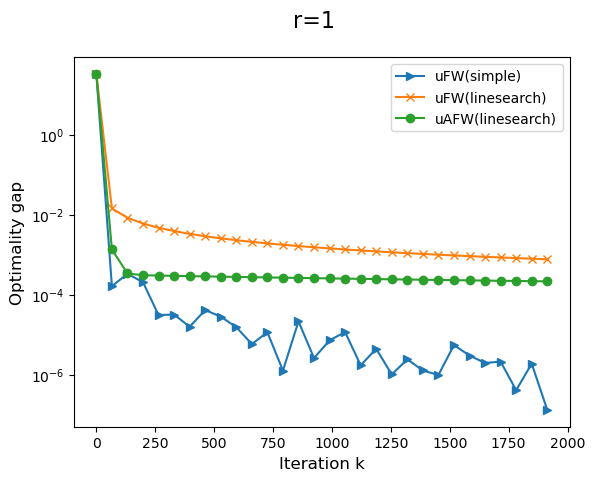

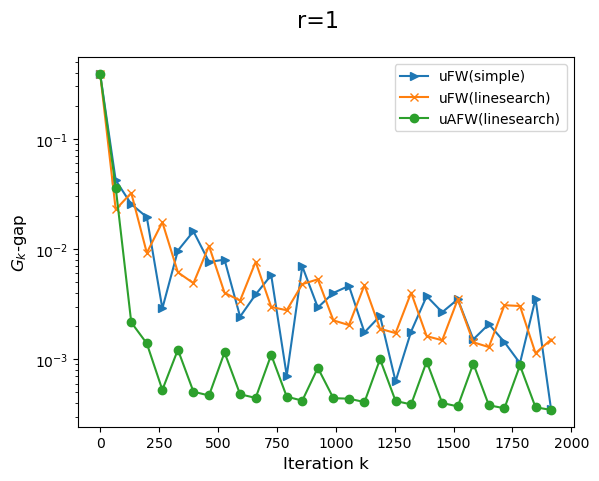

2000
15.496737241744995 15.525426387786865 19.24047064781189


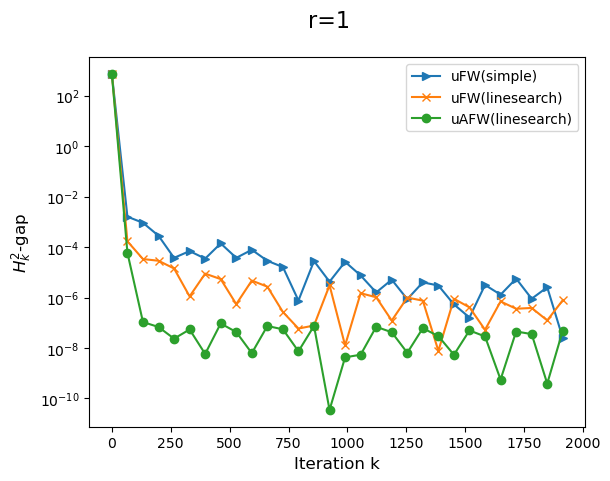

C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 51 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 52 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 56877.97194180483
L=  56877.97194180483
k= 100
grad max= 9017.857164719055
L=  9017.857164719055
k= 200
grad max= 8849.899307262443
L=  8849.899307262443
k= 300
grad max= 8291.94967639579
L=  8291.94967639579
k= 400
grad max= 8155.827960668993
L=  8155.827960668993
k= 500
grad max= 8092.483474616457
L=  8092.483474616457
k= 600
grad max= 7841.230581302415
L=  7841.230581302415
k= 700
grad max= 7849.21527799633
L=  7849.21527799633
k= 800
grad max= 7704.268501935619
L=  7704.268501935619
k= 900
grad max= 7701.533896539918
L=  7701.533896539918
k= 1000
grad max= 7669.82874907781
L=  7669.82874907781
k= 1100
grad max= 7618.35549556569
L=  7618.35549556569
k= 1200
grad max= 7558.522289211077
L=  7558.522289211077
k= 1300
grad max= 7513.04740133804
L=  7513.04740133804
k= 1400
grad max= 7472.173193142496
L=  7472.173193142496
k= 1500
grad max= 7513.089333337185
L=  7513.089333337185
k= 1600
grad max= 7485.262192180721
L=  7485.262192180721
k= 1700
grad max= 7473.8281604708
L=

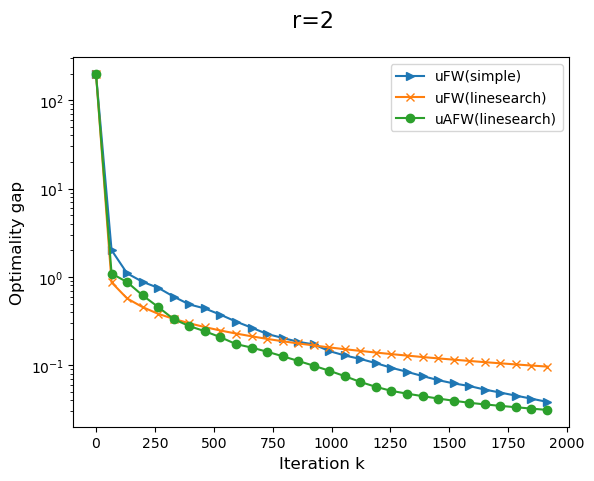

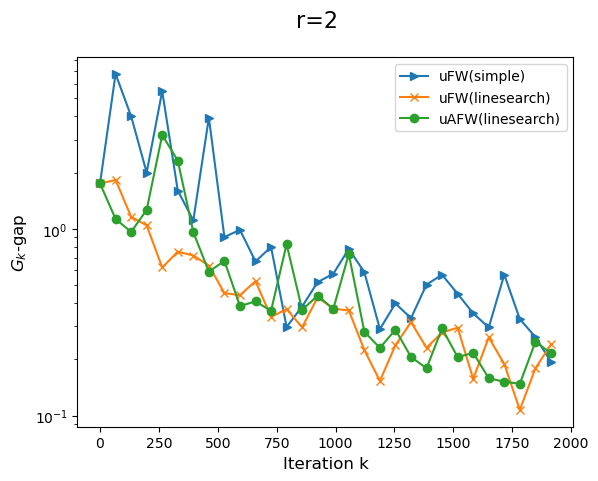

2000
11.300042152404785 13.412830829620361 12.362828969955444


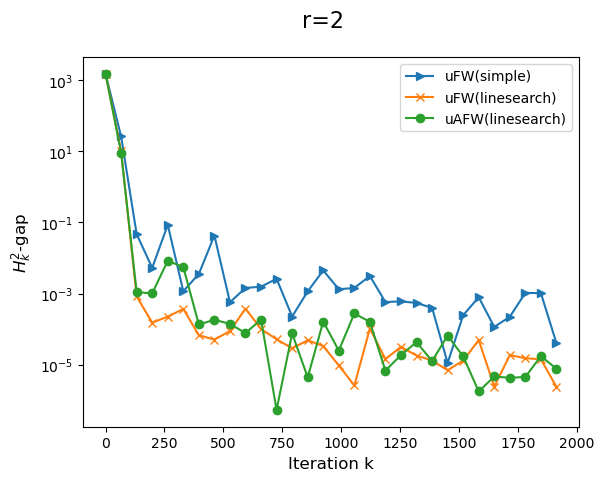

In [23]:
N = 1000
n = 500
itermax = 2000
np.random.seed(4)
rand_seeds = np.random.randint(1000, size= 10)
print(rand_seeds)


plotting(r = 1, N=N, n=n, delta= 1, repeat = 1,
         random_seeds = rand_seeds, gradient_ss = 'other', itermax = itermax)

plotting(r = 2, N=N, n=n, delta= 1, repeat = 1,
         random_seeds = rand_seeds, gradient_ss = 'other', itermax = itermax)

[681 238 121 581 321 635 452 381 415 772]


C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 53 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 54 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 3150.03731980773
L=  3150.03731980773
k= 100
grad max= 611.8720533997935
L=  611.8720533997935
k= 200
grad max= 641.7495029047504
L=  641.7495029047504
k= 300
grad max= 629.1450515554025
L=  629.1450515554025
k= 400
grad max= 640.973419861567
L=  640.973419861567
k= 500
grad max= 638.8585703964222
L=  638.8585703964222
k= 600
grad max= 634.3090471171431
L=  634.3090471171431
k= 700
grad max= 639.2246843248008
L=  639.2246843248008
k= 800
grad max= 639.736956671833
L=  639.736956671833
k= 900
grad max= 639.3812134866289
L=  639.3812134866289
k= 1000
grad max= 637.2141365886146
L=  637.2141365886146
k= 1100
grad max= 639.4064504008879
L=  639.4064504008879
k= 1200
grad max= 639.9727354673055
L=  639.9727354673055
k= 1300
grad max= 640.0149154467267
L=  640.0149154467267
k= 1400
grad max= 638.2578483716034
L=  638.2578483716034
k= 1500
grad max= 639.8718560190368
L=  639.8718560190368
k= 1600
grad max= 639.5769830916129
L=  639.5769830916129
k= 1700
grad max= 640.4131457685

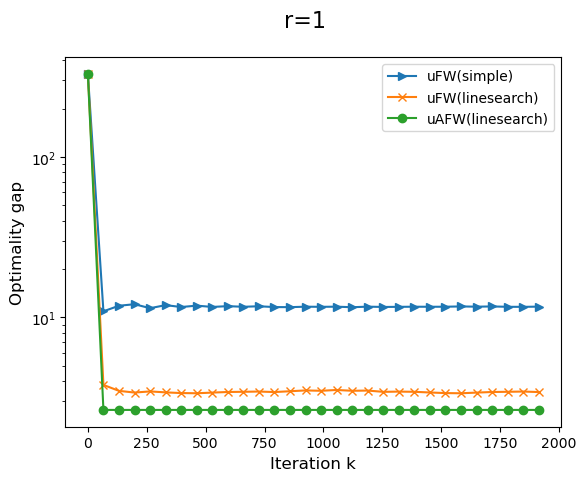

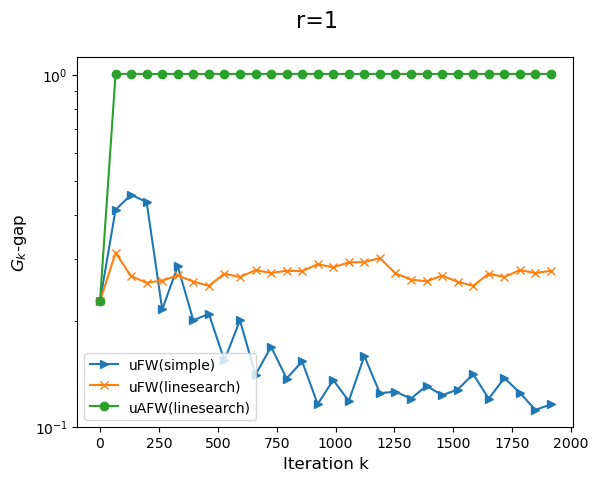

2000
13.947538375854492 13.904666185379028 20.891062259674072


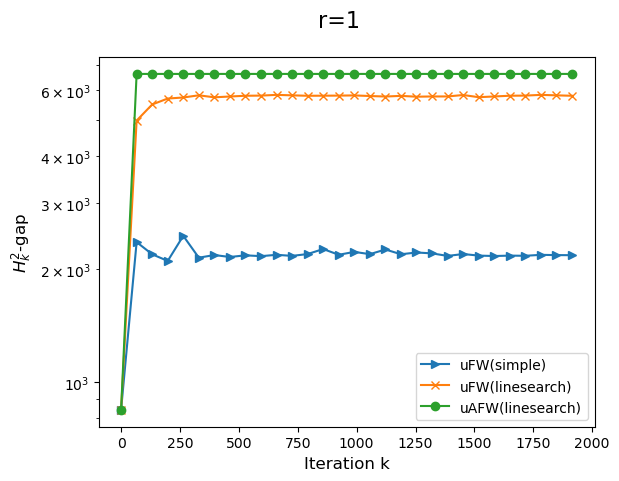

C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 55 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 56 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 52954.6632577126
L=  52954.6632577126
k= 100
grad max= 9570.325037276361
L=  9570.325037276361
k= 200
grad max= 8186.58648389918
L=  8186.58648389918
k= 300
grad max= 8397.047365920018
L=  8397.047365920018
k= 400
grad max= 8085.9806229524365
L=  8085.9806229524365
k= 500
grad max= 8002.004712213795
L=  8002.004712213795
k= 600
grad max= 7820.198076359829
L=  7820.198076359829
k= 700
grad max= 7823.592832035258
L=  7823.592832035258
k= 800
grad max= 7649.55747645249
L=  7649.55747645249
k= 900
grad max= 7625.289395245238
L=  7625.289395245238
k= 1000
grad max= 7568.096172422376
L=  7568.096172422376
k= 1100
grad max= 7610.232438678837
L=  7610.232438678837
k= 1200
grad max= 7545.71123554457
L=  7545.71123554457
k= 1300
grad max= 7530.786946206374
L=  7530.786946206374
k= 1400
grad max= 7465.815370841503
L=  7465.815370841503
k= 1500
grad max= 7489.719753175448
L=  7489.719753175448
k= 1600
grad max= 7490.980862426039
L=  7490.980862426039
k= 1700
grad max= 7461.892078744

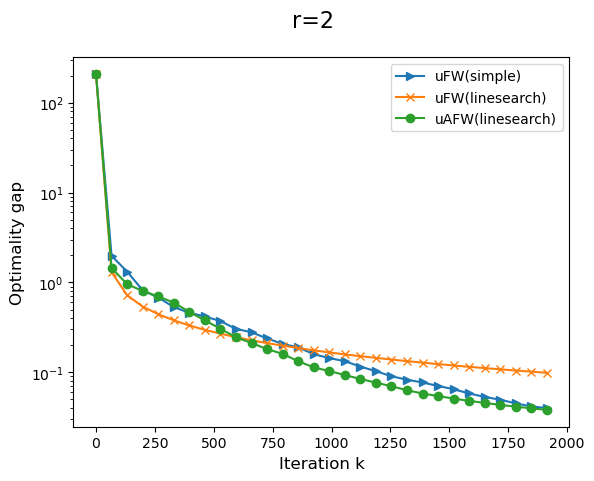

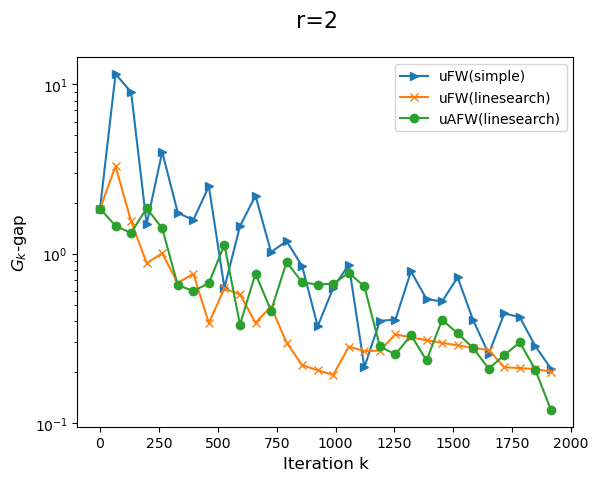

2000
12.436233043670654 10.806113481521606 12.903624534606934


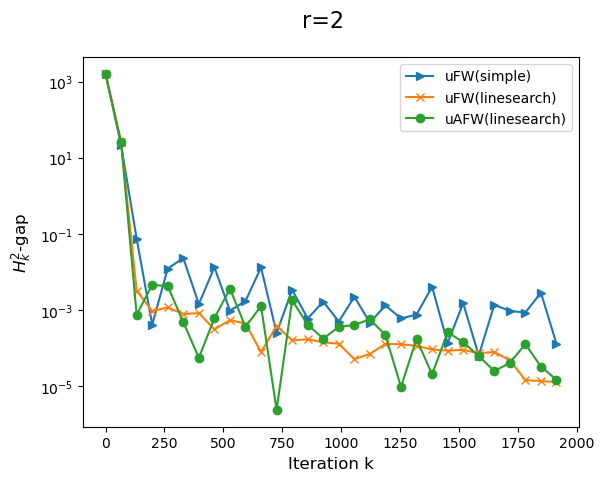

In [24]:
N = 1000
n = 500
itermax = 2000
np.random.seed(16)
rand_seeds = np.random.randint(1000, size=10)
print(rand_seeds)


plotting(r = 1, N=N, n=n, delta= 1, repeat = 1,
         random_seeds = rand_seeds, gradient_ss = 'other', itermax = itermax)

plotting(r = 2, N=N, n=n, delta= 1, repeat = 1,
         random_seeds = rand_seeds, gradient_ss = 'other', itermax = itermax)

[619 344 268 406 327 761 358 746 668 650]


C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 57 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 58 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 3272.581266537947
L=  3272.581266537947
k= 100
grad max= 892.3077618387592
L=  892.3077618387592
k= 200
grad max= 890.0423903329165
L=  890.0423903329165
k= 300
grad max= 891.2686905204632
L=  891.2686905204632
k= 400
grad max= 892.5857929926137
L=  892.5857929926137
k= 500
grad max= 891.2238426274648
L=  891.2238426274648
k= 600
grad max= 891.6300525752908
L=  891.6300525752908
k= 700
grad max= 891.1071769765031
L=  891.1071769765031
k= 800
grad max= 891.4465670555774
L=  891.4465670555774
k= 900
grad max= 891.0822916959805
L=  891.0822916959805
k= 1000
grad max= 891.3543880384104
L=  891.3543880384104
k= 1100
grad max= 890.8376306221744
L=  890.8376306221744
k= 1200
grad max= 891.0938543132283
L=  891.0938543132283
k= 1300
grad max= 890.8620290135232
L=  890.8620290135232
k= 1400
grad max= 893.2781215400128
L=  893.2781215400128
k= 1500
grad max= 893.3425557382898
L=  893.3425557382898
k= 1600
grad max= 892.8452215111615
L=  892.8452215111615
k= 1700
grad max= 892.9327

C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 59 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 60 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 4389.844459292936
L=  4389.844459292936
k= 100
grad max= 941.168818629635
L=  941.168818629635
k= 200
grad max= 942.4560962432098
L=  942.4560962432098
k= 300
grad max= 944.4412339018006
L=  944.4412339018006
k= 400
grad max= 944.166141556922
L=  944.166141556922
k= 500
grad max= 943.9852299518152
L=  943.9852299518152
k= 600
grad max= 943.8579615455229
L=  943.8579615455229
k= 700
grad max= 943.838945006492
L=  943.838945006492
k= 800
grad max= 943.7550062026755
L=  943.7550062026755
k= 900
grad max= 944.2384168894564
L=  944.2384168894564
k= 1000
grad max= 944.1289444562565
L=  944.1289444562565
k= 1100
grad max= 944.0365072002324
L=  944.0365072002324
k= 1200
grad max= 943.9599926444491
L=  943.9599926444491
k= 1300
grad max= 943.9358314186869
L=  943.9358314186869
k= 1400
grad max= 944.2302952564442
L=  944.2302952564442
k= 1500
grad max= 944.15482201031
L=  944.15482201031
k= 1600
grad max= 944.0877537760865
L=  944.0877537760865
k= 1700
grad max= 944.0290559942279


C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 61 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 62 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 3637.227441302456
L=  3637.227441302456
k= 100
grad max= 622.1161701723386
L=  622.1161701723386
k= 200
grad max= 612.681268905545
L=  612.681268905545
k= 300
grad max= 614.6971223179326
L=  614.6971223179326
k= 400
grad max= 612.37513009594
L=  612.37513009594
k= 500
grad max= 613.2025153226975
L=  613.2025153226975
k= 600
grad max= 612.3633242420628
L=  612.3633242420628
k= 700
grad max= 613.046933585382
L=  613.046933585382
k= 800
grad max= 612.4733661514995
L=  612.4733661514995
k= 900
grad max= 613.0025434454674
L=  613.0025434454674
k= 1000
grad max= 612.2785499581023
L=  612.2785499581023
k= 1100
grad max= 612.9547039157194
L=  612.9547039157194
k= 1200
grad max= 612.3883101456811
L=  612.3883101456811
k= 1300
grad max= 612.9700988015093
L=  612.9700988015093
k= 1400
grad max= 612.4505977672036
L=  612.4505977672036
k= 1500
grad max= 612.0302624311196
L=  612.0302624311196
k= 1600
grad max= 612.5340623402451
L=  612.5340623402451
k= 1700
grad max= 612.133472800612

C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 63 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 64 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 3073.434679086936
L=  3073.434679086936
k= 100
grad max= 959.2327285698631
L=  959.2327285698631
k= 200
grad max= 957.0629788654966
L=  957.0629788654966
k= 300
grad max= 955.7257144378881
L=  955.7257144378881
k= 400
grad max= 957.854776230089
L=  957.854776230089
k= 500
grad max= 956.9965649043631
L=  956.9965649043631
k= 600
grad max= 956.4906322774802
L=  956.4906322774802
k= 700
grad max= 956.5580140328569
L=  956.5580140328569
k= 800
grad max= 956.2929652296721
L=  956.2929652296721
k= 900
grad max= 957.1055204130332
L=  957.1055204130332
k= 1000
grad max= 956.7854272668754
L=  956.7854272668754
k= 1100
grad max= 956.8826014830303
L=  956.8826014830303
k= 1200
grad max= 956.6464535745555
L=  956.6464535745555
k= 1300
grad max= 956.4483139998583
L=  956.4483139998583
k= 1400
grad max= 956.5074376529839
L=  956.5074376529839
k= 1500
grad max= 956.3418455459472
L=  956.3418455459472
k= 1600
grad max= 956.8402444581352
L=  956.8402444581352
k= 1700
grad max= 956.673265

C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 65 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 66 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 2918.158400220917
L=  2918.158400220917
k= 100
grad max= 487.5847739630617
L=  487.5847739630617
k= 200
grad max= 479.43209251511325
L=  479.43209251511325
k= 300
grad max= 479.305432742804
L=  479.305432742804
k= 400
grad max= 480.026974176109
L=  480.026974176109
k= 500
grad max= 478.57793571453476
L=  478.57793571453476
k= 600
grad max= 478.63589845238675
L=  478.63589845238675
k= 700
grad max= 478.84126448043276
L=  478.84126448043276
k= 800
grad max= 478.87317107552667
L=  478.87317107552667
k= 900
grad max= 479.1084050768186
L=  479.1084050768186
k= 1000
grad max= 478.8153347174459
L=  478.8153347174459
k= 1100
grad max= 479.14370187970053
L=  479.14370187970053
k= 1200
grad max= 479.09210115762903
L=  479.09210115762903
k= 1300
grad max= 479.0535637336452
L=  479.0535637336452
k= 1400
grad max= 479.21962352371474
L=  479.21962352371474
k= 1500
grad max= 479.1799619127755
L=  479.1799619127755
k= 1600
grad max= 479.12815667886684
L=  479.12815667886684
k= 1700
grad

C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 67 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 68 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 3629.4231317805675
L=  3629.4231317805675
k= 100
grad max= 1067.058497587686
L=  1067.058497587686
k= 200
grad max= 1064.9218438393068
L=  1064.9218438393068
k= 300
grad max= 1063.9000975735116
L=  1063.9000975735116
k= 400
grad max= 1063.2930766160034
L=  1063.2930766160034
k= 500
grad max= 1063.1480185559894
L=  1063.1480185559894
k= 600
grad max= 1063.129250575293
L=  1063.129250575293
k= 700
grad max= 1064.4869349615851
L=  1064.4869349615851
k= 800
grad max= 1064.089403923504
L=  1064.089403923504
k= 900
grad max= 1063.7561142174095
L=  1063.7561142174095
k= 1000
grad max= 1063.5003841295206
L=  1063.5003841295206
k= 1100
grad max= 1063.3895196745784
L=  1063.3895196745784
k= 1200
grad max= 1063.23759964583
L=  1063.23759964583
k= 1300
grad max= 1064.0299431769358
L=  1064.0299431769358
k= 1400
grad max= 1063.825000970187
L=  1063.825000970187
k= 1500
grad max= 1063.633309183017
L=  1063.633309183017
k= 1600
grad max= 1063.544639195929
L=  1063.544639195929
k= 1700


C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 69 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 70 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 3944.609200149355
L=  3944.609200149355
k= 100
grad max= 553.9078812500916
L=  553.9078812500916
k= 200
grad max= 577.3445865002504
L=  577.3445865002504
k= 300
grad max= 586.306100110558
L=  586.306100110558
k= 400
grad max= 578.1193857217131
L=  578.1193857217131
k= 500
grad max= 583.232689721498
L=  583.232689721498
k= 600
grad max= 575.8371036784474
L=  575.8371036784474
k= 700
grad max= 578.0016536702178
L=  578.0016536702178
k= 800
grad max= 576.229175354822
L=  576.229175354822
k= 900
grad max= 575.1654640024976
L=  575.1654640024976
k= 1000
grad max= 576.713162405928
L=  576.713162405928
k= 1100
grad max= 577.908892051702
L=  577.908892051702
k= 1200
grad max= 576.9576674725513
L=  576.9576674725513
k= 1300
grad max= 577.3151620620743
L=  577.3151620620743
k= 1400
grad max= 576.4978241408171
L=  576.4978241408171
k= 1500
grad max= 577.3575676890246
L=  577.3575676890246
k= 1600
grad max= 576.688194867017
L=  576.688194867017
k= 1700
grad max= 577.5116794872629
L=

C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 71 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 72 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 3510.7127908309194
L=  3510.7127908309194
k= 100
grad max= 469.20175544704233
L=  469.20175544704233
k= 200
grad max= 471.688427500509
L=  471.688427500509
k= 300
grad max= 467.8505082704423
L=  467.8505082704423
k= 400
grad max= 468.2376291046423
L=  468.2376291046423
k= 500
grad max= 468.9902862816659
L=  468.9902862816659
k= 600
grad max= 469.06799702175346
L=  469.06799702175346
k= 700
grad max= 468.0513670639289
L=  468.0513670639289
k= 800
grad max= 468.39618721085964
L=  468.39618721085964
k= 900
grad max= 468.61538924207474
L=  468.61538924207474
k= 1000
grad max= 467.8772370442438
L=  467.8772370442438
k= 1100
grad max= 468.38964731335165
L=  468.38964731335165
k= 1200
grad max= 468.7036588751958
L=  468.7036588751958
k= 1300
grad max= 468.1881567455136
L=  468.1881567455136
k= 1400
grad max= 468.31496436746653
L=  468.31496436746653
k= 1500
grad max= 468.5710161252852
L=  468.5710161252852
k= 1600
grad max= 468.70649444946713
L=  468.70649444946713
k= 1700
grad

C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 73 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 74 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 3415.4831965171547
L=  3415.4831965171547
k= 100
grad max= 585.0026394127535
L=  585.0026394127535
k= 200
grad max= 610.796198723212
L=  610.796198723212
k= 300
grad max= 603.3962004584805
L=  603.3962004584805
k= 400
grad max= 626.890273154871
L=  626.890273154871
k= 500
grad max= 591.5146114210461
L=  591.5146114210461
k= 600
grad max= 615.8122424971243
L=  615.8122424971243
k= 700
grad max= 616.6075183980652
L=  616.6075183980652
k= 800
grad max= 606.2881094725412
L=  606.2881094725412
k= 900
grad max= 587.6674594803867
L=  587.6674594803867
k= 1000
grad max= 613.28276821505
L=  613.28276821505
k= 1100
grad max= 606.6400467881285
L=  606.6400467881285
k= 1200
grad max= 595.1345785821545
L=  595.1345785821545
k= 1300
grad max= 597.248273589043
L=  597.248273589043
k= 1400
grad max= 608.6041790146683
L=  608.6041790146683
k= 1500
grad max= 598.985074193989
L=  598.985074193989
k= 1600
grad max= 598.4337523683271
L=  598.4337523683271
k= 1700
grad max= 598.187824958185
L

C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 75 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 76 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 4093.1255276711086
L=  4093.1255276711086
k= 100
grad max= 718.1200902847645
L=  718.1200902847645
k= 200
grad max= 712.9368701451358
L=  712.9368701451358
k= 300
grad max= 714.5493663893276
L=  714.5493663893276
k= 400
grad max= 710.8581704715043
L=  710.8581704715043
k= 500
grad max= 711.6590042883122
L=  711.6590042883122
k= 600
grad max= 715.143043109867
L=  715.143043109867
k= 700
grad max= 712.9729692039532
L=  712.9729692039532
k= 800
grad max= 713.0938852920485
L=  713.0938852920485
k= 900
grad max= 713.8879613134104
L=  713.8879613134104
k= 1000
grad max= 713.7438369786587
L=  713.7438369786587
k= 1100
grad max= 714.361870500406
L=  714.361870500406
k= 1200
grad max= 713.7377731676074
L=  713.7377731676074
k= 1300
grad max= 714.004467892793
L=  714.004467892793
k= 1400
grad max= 712.5718604358699
L=  712.5718604358699
k= 1500
grad max= 713.3439310064814
L=  713.3439310064814
k= 1600
grad max= 713.7614011758865
L=  713.7614011758865
k= 1700
grad max= 713.26938494

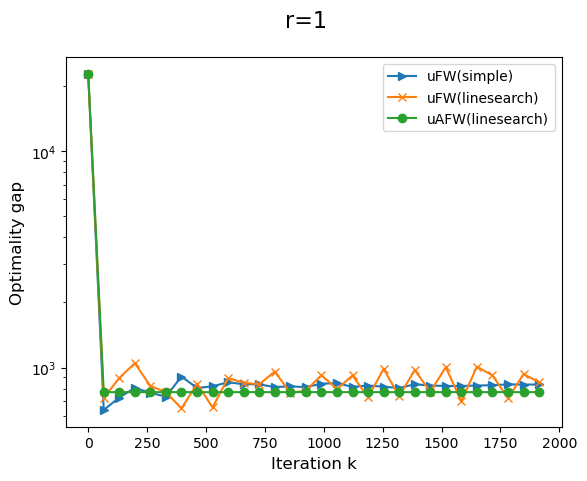

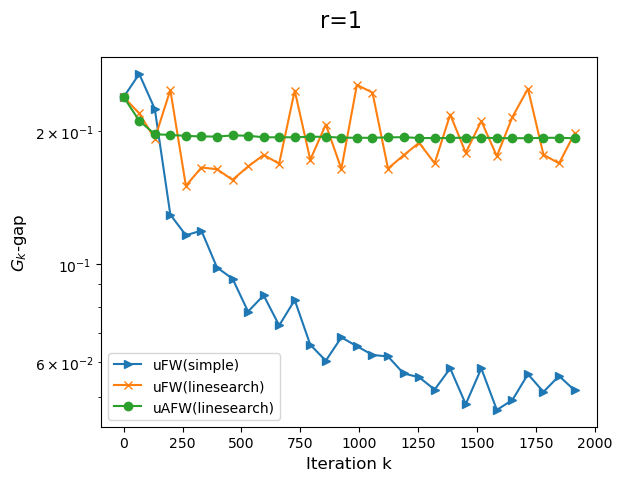

2000
13.306761169433594 11.907567501068115 20.143697834014894


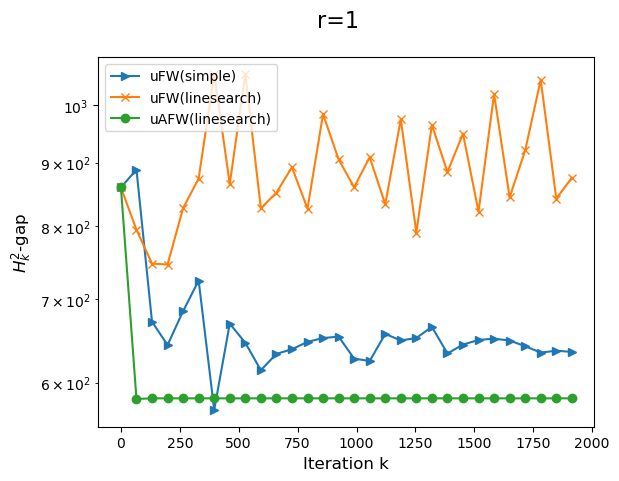

C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 77 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 78 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 54549.90886665265
L=  54549.90886665265
k= 100
grad max= 8667.973276349825
L=  8667.973276349825
k= 200
grad max= 7533.055768839875
L=  7533.055768839875
k= 300
grad max= 6649.314155432712
L=  6649.314155432712
k= 400
grad max= 6622.570740338979
L=  6622.570740338979
k= 500
grad max= 6292.79485301034
L=  6292.79485301034
k= 600
grad max= 6170.706737874513
L=  6170.706737874513
k= 700
grad max= 6079.568897688284
L=  6079.568897688284
k= 800
grad max= 5954.288933809465
L=  5954.288933809465
k= 900
grad max= 5887.882357414817
L=  5887.882357414817
k= 1000
grad max= 5842.545341155395
L=  5842.545341155395
k= 1100
grad max= 5803.527656419584
L=  5803.527656419584
k= 1200
grad max= 5813.841311698122
L=  5813.841311698122
k= 1300
grad max= 5794.822454687371
L=  5794.822454687371
k= 1400
grad max= 5803.869263366522
L=  5803.869263366522
k= 1500
grad max= 5828.743554543405
L=  5828.743554543405
k= 1600
grad max= 5835.8220148861865
L=  5835.8220148861865
k= 1700
grad max= 5811.201

C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 79 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 80 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 58842.24465289137
L=  58842.24465289137
k= 100
grad max= 10100.440663512749
L=  10100.440663512749
k= 200
grad max= 8614.351102441706
L=  8614.351102441706
k= 300
grad max= 8259.622914879568
L=  8259.622914879568
k= 400
grad max= 7919.122623702795
L=  7919.122623702795
k= 500
grad max= 7852.246617061537
L=  7852.246617061537
k= 600
grad max= 7654.523351074578
L=  7654.523351074578
k= 700
grad max= 7421.748350101301
L=  7421.748350101301
k= 800
grad max= 7327.047666742168
L=  7327.047666742168
k= 900
grad max= 7274.44844059055
L=  7274.44844059055
k= 1000
grad max= 7272.994827788458
L=  7272.994827788458
k= 1100
grad max= 7224.184502357832
L=  7224.184502357832
k= 1200
grad max= 7136.039035958678
L=  7136.039035958678
k= 1300
grad max= 7137.347583894887
L=  7137.347583894887
k= 1400
grad max= 7148.372101966015
L=  7148.372101966015
k= 1500
grad max= 7076.046494681967
L=  7076.046494681967
k= 1600
grad max= 7107.117683428296
L=  7107.117683428296
k= 1700
grad max= 7090.884

C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 81 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 82 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 59567.262738284495
L=  59567.262738284495
k= 100
grad max= 9676.896724985643
L=  9676.896724985643
k= 200
grad max= 9728.735744352354
L=  9728.735744352354
k= 300
grad max= 9624.563729317757
L=  9624.563729317757
k= 400
grad max= 9487.237731922924
L=  9487.237731922924
k= 500
grad max= 9355.939249408511
L=  9355.939249408511
k= 600
grad max= 9337.894222937459
L=  9337.894222937459
k= 700
grad max= 9221.024378669059
L=  9221.024378669059
k= 800
grad max= 9280.062766211166
L=  9280.062766211166
k= 900
grad max= 9168.057339484276
L=  9168.057339484276
k= 1000
grad max= 9092.440283579763
L=  9092.440283579763
k= 1100
grad max= 9036.032511495614
L=  9036.032511495614
k= 1200
grad max= 8978.341966320608
L=  8978.341966320608
k= 1300
grad max= 8958.40082831115
L=  8958.40082831115
k= 1400
grad max= 8969.701928246308
L=  8969.701928246308
k= 1500
grad max= 8910.079825859637
L=  8910.079825859637
k= 1600
grad max= 8880.536171318705
L=  8880.536171318705
k= 1700
grad max= 8883.970

C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 83 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 84 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 52439.99074111077
L=  52439.99074111077
k= 100
grad max= 9487.737070071802
L=  9487.737070071802
k= 200
grad max= 8714.996463456002
L=  8714.996463456002
k= 300
grad max= 8574.413652123287
L=  8574.413652123287
k= 400
grad max= 8400.509414247113
L=  8400.509414247113
k= 500
grad max= 8294.381905835127
L=  8294.381905835127
k= 600
grad max= 8295.02115418348
L=  8295.02115418348
k= 700
grad max= 8107.325522652371
L=  8107.325522652371
k= 800
grad max= 8083.494501693702
L=  8083.494501693702
k= 900
grad max= 8127.993506953846
L=  8127.993506953846
k= 1000
grad max= 8054.956115131747
L=  8054.956115131747
k= 1100
grad max= 7968.861078461727
L=  7968.861078461727
k= 1200
grad max= 7998.548173207622
L=  7998.548173207622
k= 1300
grad max= 8001.670378076167
L=  8001.670378076167
k= 1400
grad max= 8037.583416960324
L=  8037.583416960324
k= 1500
grad max= 8006.181981592827
L=  8006.181981592827
k= 1600
grad max= 7987.209621303071
L=  7987.209621303071
k= 1700
grad max= 8032.49736

C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 85 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 86 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 55037.689798876185
L=  55037.689798876185
k= 100
grad max= 10285.853984051995
L=  10285.853984051995
k= 200
grad max= 9688.963409687356
L=  9688.963409687356
k= 300
grad max= 9396.680731427361
L=  9396.680731427361
k= 400
grad max= 9125.618866064702
L=  9125.618866064702
k= 500
grad max= 8993.715430686287
L=  8993.715430686287
k= 600
grad max= 8866.628867749816
L=  8866.628867749816
k= 700
grad max= 8722.409193021449
L=  8722.409193021449
k= 800
grad max= 8582.119043022387
L=  8582.119043022387
k= 900
grad max= 8481.837384701052
L=  8481.837384701052
k= 1000
grad max= 8402.201218595386
L=  8402.201218595386
k= 1100
grad max= 8324.792853824452
L=  8324.792853824452
k= 1200
grad max= 8275.302137976876
L=  8275.302137976876
k= 1300
grad max= 8242.807251925879
L=  8242.807251925879
k= 1400
grad max= 8190.661231684535
L=  8190.661231684535
k= 1500
grad max= 8163.8298712205
L=  8163.8298712205
k= 1600
grad max= 8118.772424261668
L=  8118.772424261668
k= 1700
grad max= 8091.027

C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 87 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 88 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 67555.14378145104
L=  67555.14378145104
k= 100
grad max= 9398.326888201247
L=  9398.326888201247
k= 200
grad max= 8711.12185192486
L=  8711.12185192486
k= 300
grad max= 8420.903280762775
L=  8420.903280762775
k= 400
grad max= 8288.421871321336
L=  8288.421871321336
k= 500
grad max= 8092.102091202067
L=  8092.102091202067
k= 600
grad max= 7971.994866812134
L=  7971.994866812134
k= 700
grad max= 7838.165839755371
L=  7838.165839755371
k= 800
grad max= 7721.50641181904
L=  7721.50641181904
k= 900
grad max= 7641.233795230657
L=  7641.233795230657
k= 1000
grad max= 7524.353107238696
L=  7524.353107238696
k= 1100
grad max= 7483.100737423692
L=  7483.100737423692
k= 1200
grad max= 7433.907027660278
L=  7433.907027660278
k= 1300
grad max= 7354.634333290678
L=  7354.634333290678
k= 1400
grad max= 7311.767421515002
L=  7311.767421515002
k= 1500
grad max= 7295.242182180986
L=  7295.242182180986
k= 1600
grad max= 7267.638289845769
L=  7267.638289845769
k= 1700
grad max= 7254.1914440

C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 89 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 90 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 57459.96594250683
L=  57459.96594250683
k= 100
grad max= 9695.544422987212
L=  9695.544422987212
k= 200
grad max= 9303.78242519109
L=  9303.78242519109
k= 300
grad max= 9078.809271189017
L=  9078.809271189017
k= 400
grad max= 9009.340730303185
L=  9009.340730303185
k= 500
grad max= 8973.42990783829
L=  8973.42990783829
k= 600
grad max= 8946.462633380894
L=  8946.462633380894
k= 700
grad max= 8860.786285334949
L=  8860.786285334949
k= 800
grad max= 8860.226793930144
L=  8860.226793930144
k= 900
grad max= 8776.47513754662
L=  8776.47513754662
k= 1000
grad max= 8799.9462915617
L=  8799.9462915617
k= 1100
grad max= 8788.845858964036
L=  8788.845858964036
k= 1200
grad max= 8770.74655522905
L=  8770.74655522905
k= 1300
grad max= 8727.117255797191
L=  8727.117255797191
k= 1400
grad max= 8749.419195995695
L=  8749.419195995695
k= 1500
grad max= 8747.820255910661
L=  8747.820255910661
k= 1600
grad max= 8734.291212099895
L=  8734.291212099895
k= 1700
grad max= 8729.993505228973
L=

C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 91 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 92 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 56469.7317837005
L=  56469.7317837005
k= 100
grad max= 9020.0804289822
L=  9020.0804289822
k= 200
grad max= 8832.08383310218
L=  8832.08383310218
k= 300
grad max= 8552.453034903883
L=  8552.453034903883
k= 400
grad max= 8370.061887746062
L=  8370.061887746062
k= 500
grad max= 8318.01725026403
L=  8318.01725026403
k= 600
grad max= 8221.16820765645
L=  8221.16820765645
k= 700
grad max= 8146.1280357722535
L=  8146.1280357722535
k= 800
grad max= 8126.085049126366
L=  8126.085049126366
k= 900
grad max= 8051.055823672938
L=  8051.055823672938
k= 1000
grad max= 7986.480639644786
L=  7986.480639644786
k= 1100
grad max= 7938.24726351368
L=  7938.24726351368
k= 1200
grad max= 7909.392119259479
L=  7909.392119259479
k= 1300
grad max= 7904.233246789932
L=  7904.233246789932
k= 1400
grad max= 7867.942309285914
L=  7867.942309285914
k= 1500
grad max= 7846.641697305178
L=  7846.641697305178
k= 1600
grad max= 7853.285132852961
L=  7853.285132852961
k= 1700
grad max= 7839.2260089878655
L

C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 93 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 94 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 55903.05115864119
L=  55903.05115864119
k= 100
grad max= 8261.674702420456
L=  8261.674702420456
k= 200
grad max= 7883.640170309752
L=  7883.640170309752
k= 300
grad max= 7605.626796651224
L=  7605.626796651224
k= 400
grad max= 7443.378268308412
L=  7443.378268308412
k= 500
grad max= 7385.350513607537
L=  7385.350513607537
k= 600
grad max= 7349.851187070743
L=  7349.851187070743
k= 700
grad max= 7307.210911476915
L=  7307.210911476915
k= 800
grad max= 7144.375684768315
L=  7144.375684768315
k= 900
grad max= 7198.8098860471255
L=  7198.8098860471255
k= 1000
grad max= 7211.024650011561
L=  7211.024650011561
k= 1100
grad max= 7216.410469707028
L=  7216.410469707028
k= 1200
grad max= 7259.71127546424
L=  7259.71127546424
k= 1300
grad max= 7141.425537598836
L=  7141.425537598836
k= 1400
grad max= 7158.507402491801
L=  7158.507402491801
k= 1500
grad max= 7204.093609719952
L=  7204.093609719952
k= 1600
grad max= 7191.9032733490485
L=  7191.9032733490485
k= 1700
grad max= 7122.6

C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 95 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 96 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\Bertug\

k= 0
grad max= 54273.7473083113
L=  54273.7473083113
k= 100
grad max= 9232.509790804259
L=  9232.509790804259
k= 200
grad max= 8688.89296679365
L=  8688.89296679365
k= 300
grad max= 8254.396560550227
L=  8254.396560550227
k= 400
grad max= 8068.319716932048
L=  8068.319716932048
k= 500
grad max= 7938.464720000009
L=  7938.464720000009
k= 600
grad max= 7908.680246727972
L=  7908.680246727972
k= 700
grad max= 7689.538684869938
L=  7689.538684869938
k= 800
grad max= 7527.984728770201
L=  7527.984728770201
k= 900
grad max= 7499.759258921507
L=  7499.759258921507
k= 1000
grad max= 7514.617898051589
L=  7514.617898051589
k= 1100
grad max= 7519.906189008696
L=  7519.906189008696
k= 1200
grad max= 7514.382563288989
L=  7514.382563288989
k= 1300
grad max= 7537.209663075837
L=  7537.209663075837
k= 1400
grad max= 7535.649845693872
L=  7535.649845693872
k= 1500
grad max= 7537.0081553806995
L=  7537.0081553806995
k= 1600
grad max= 7553.06764572304
L=  7553.06764572304
k= 1700
grad max= 7537.4857668

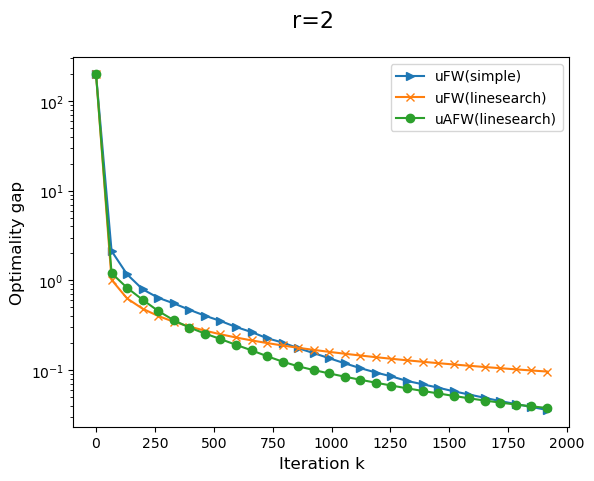

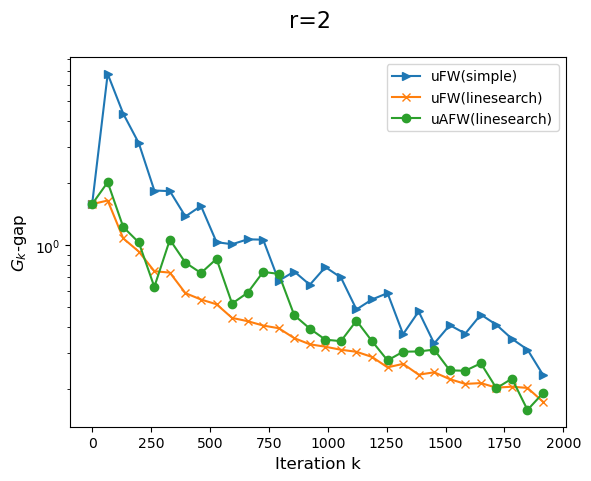

2000
12.218083953857422 13.282489466667176 12.597797775268555


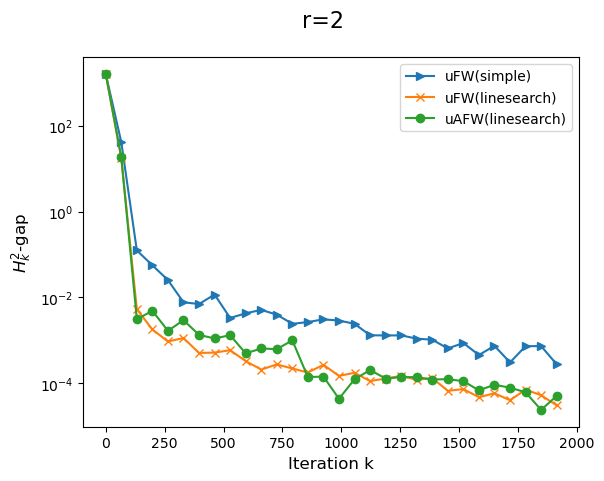

In [25]:
N = 1000
n = 500
itermax = 2000
np.random.seed(14)
rand_seeds = np.random.randint(1000, size= 10)
print(rand_seeds)


plotting(r = 1, N=N, n=n, delta= 1, repeat = 10,
         random_seeds = rand_seeds, gradient_ss = 'other', itermax = itermax)

plotting(r = 2, N=N, n=n, delta= 1, repeat = 10,
         random_seeds = rand_seeds, gradient_ss = 'other', itermax = itermax)